[Previous: Time series regression models](07-Time-series-regression-models.ipynb)
• [Contents](Contents.ipynb)
• [Next: ARIMA-models](09-ARIMA-models.ipynb)

# 8 Exponential smoothing

[FPP3 Chapter 8](https://otexts.com/fpp3/expsmooth.html)

* [8.1 Simple exponential smoothing](#8.1-Simple-exponential-smoothing)
* [8.2 Methods with trend](#8.2-Methods-with-trend)
* [8.3 Methods with seasonality](#8.3-Methods-with-seasonality)
* [8.4 A taxonomy of exponential smoothing methods](#8.4-A-taxonomy-of-exponential-smoothing-methods)
* [8.5 Innovations state space models for exponential smoothing](#8.5-Innovations-state-space-models-for-exponential-smoothing)
* [8.6 Estimation and model selection](#8.6-Estimation-and-model-selection)
* [8.7 Forecasting with ETS models](#8.7-Forecasting-with-ETS-models)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 8.1 Simple exponential smoothing

[FPP3 Section 8.1](https://otexts.com/fpp3/ses.html)

In [2]:
global_economy = (
    pd.read_csv('data/tsibbledata/global_economy.csv', parse_dates=['Year'])
    .rename(columns={'Year':'Date'})
    .pipe(compute, lambda x: dict(Pop = x.Population / 1e6))
)

In [3]:
algeria_economy = (
    global_economy.query("Country == 'Algeria'")
    .set_index('Date')
    .pipe(set_freq)
)

In [4]:
algeria_economy.head()

,Country,Code,GDP,Growth,CPI,Imports,Exports,Population,Pop
Date,,,,,,,,,
1960-01-01,Algeria,DZA,2.723649e+09,NaN,NaN,67.143632,39.043173,11124888.0,11.124888
1961-01-01,Algeria,DZA,2.434777e+09,-13.605441,NaN,67.503771,46.244557,11404859.0,11.404859
1962-01-01,Algeria,DZA,2.001469e+09,-19.685042,NaN,20.818647,19.793873,11690153.0,11.690153
1963-01-01,Algeria,DZA,2.703015e+09,34.313729,NaN,36.825515,24.684682,11985136.0,11.985136
1964-01-01,Algeria,DZA,2.909352e+09,5.839413,NaN,29.439763,25.084059,12295970.0,12.295970


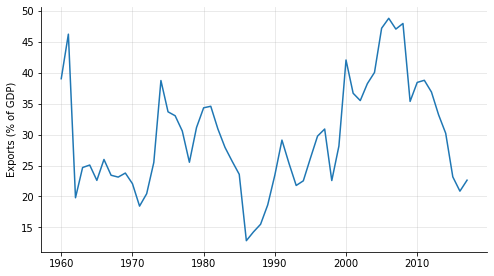

In [5]:
fig, ax = plt.subplots()
ax.plot(algeria_economy.Exports)
ax.set(ylabel='Exports (% of GDP)')
ax.grid()

### Weighted average form

### Component form

### Flat forecasts

### Optimisation

### Example: Algerian exports

In [6]:
Y = algeria_economy.Exports
X = Y.index
fit = sm.tsa.SimpleExpSmoothing(Y).fit()
fit.summary()

Dep. Variable:,endog,No. Observations:,58
Model:,SimpleExpSmoothing,SSE,1995.285
Optimized:,True,AIC,209.210
Trend:,None,BIC,213.331
Seasonal:,None,AICC,209.964
Seasonal Periods:,None,Date:,"Sat, 21 Sep 2024"
Box-Cox:,False,Time:,21:04:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8397837,alpha,True
initial_level,39.538213,l.0,True


In [7]:
fit.fittedfcast.shape, fit.fittedvalues.shape

((59,), (58,))

In [8]:
def errorscale(percent):
    return stats.norm.isf((1 - percent/100) / 2)

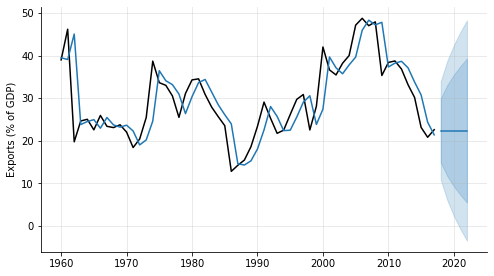

In [9]:
fig, ax = plt.subplots()

ax.plot(Y, 'k')

ax.plot(fit.fittedvalues)
sigma = (Y - fit.fittedvalues).std()

fcast = fit.forecast(5)
ax.plot(fcast, color='C0')
dy = sigma * np.sqrt(1+np.arange(len(fcast)))
s = errorscale(80)
ax.fill_between(fcast.index, fcast - s*dy, fcast + s*dy, color='C0', alpha=.2)
s = errorscale(95)
ax.fill_between(fcast.index, fcast - s*dy, fcast + s*dy, color='C0', alpha=.2)

ax.set(ylabel='Exports (% of GDP)')
ax.grid()

**TODO:** It also seems to be possible to specify fit parameters explicitly in `fit()`, rather than optimizing all parameters.  That probably makes some of my SimpleTSModel classes (from [Chapter 5](05-The-forecasters-toolbox.ipynb)) unnecessary.

## 8.2 Methods with trend

[FPP3 Section 8.2](https://otexts.com/fpp3/holt.html)

### Holt’s linear trend method

### Example: Australian population

In [10]:
aus_economy = (
    global_economy
    .query("Code == 'AUS'")
    .set_index('Date')
    .pipe(set_freq)
)

In [11]:
fit = sm.tsa.ExponentialSmoothing(aus_economy.Pop, trend='add').fit()

In [12]:
fit.summary()

Dep. Variable:,endog,No. Observations:,58
Model:,ExponentialSmoothing,SSE,0.223
Optimized:,True,AIC,-314.493
Trend:,Additive,BIC,-306.251
Seasonal:,None,AICC,-312.846
Seasonal Periods:,None,Date:,"Sat, 21 Sep 2024"
Box-Cox:,False,Time:,21:04:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.3254669,beta,True


In [13]:
def summarize_holt(res):
    d = pd.DataFrame(dict(
        observation=res.data.orig_endog,
        level=res.level,
        slope=res.slope,
        season=res.season,
        forecast=res.fittedvalues))
    return d

In [14]:
summarize_holt(fit).iloc[np.r_[:5, -5:0]]

,observation,level,slope,season,forecast
Date,,,,,
1960-01-01,10.276477,10.276477,0.223798,0.0,10.276477
1961-01-01,10.483000,10.483000,0.218176,0.0,10.500275
1962-01-01,10.742000,10.742000,0.231463,0.0,10.701176
1963-01-01,10.950000,10.950000,0.223826,0.0,10.973463
1964-01-01,11.167000,11.167000,0.221605,0.0,11.173826
2013-01-01,23.145901,23.145901,0.369017,0.0,23.094889
2014-01-01,23.504138,23.504138,0.365508,0.0,23.514918
2015-01-01,23.850784,23.850784,0.359369,0.0,23.869646
2016-01-01,24.210809,24.210809,0.359583,0.0,24.210153


### Damped trend methods

### Example: Australian Population (continued)

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


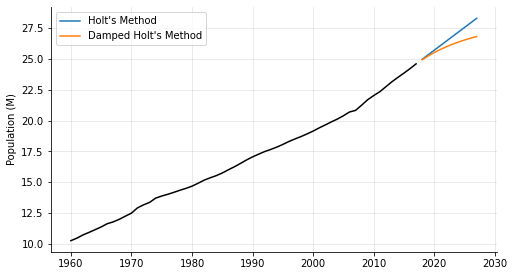

In [15]:
fig, ax = plt.subplots()
ax.plot(aus_economy.Pop, 'k')

fit = sm.tsa.ExponentialSmoothing(
    aus_economy.Pop, trend='add').fit()
ax.plot(fit.forecast(10), label="Holt's Method")

fit = sm.tsa.ExponentialSmoothing(
    aus_economy.Pop, trend='add', damped=True).fit(damping_slope=.9)
ax.plot(fit.forecast(10), label="Damped Holt's Method")

ax.legend(loc='upper left')
ax.set(ylabel='Population (M)')
ax.grid()

### Example: Internet usage

In [16]:
www_usage = rdatasets.data('datasets', 'WWWusage')

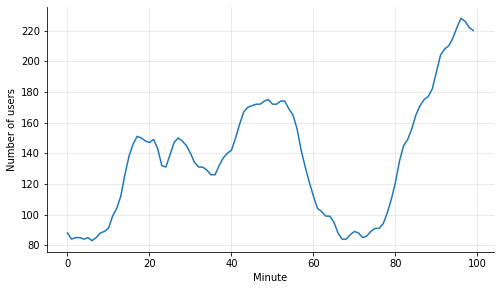

In [17]:
ax = www_usage.value.plot()
ax.set(xlabel='Minute', ylabel='Number of users')
ax.grid()

In [18]:
Y = www_usage.value
ms = dict(
    SES = sm.tsa.statespace.ExponentialSmoothing(Y).fit(),
    Holt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add').fit(),
    DampedHolt = sm.tsa.statespace.ExponentialSmoothing(Y, trend='add', damped_trend=True).fit(),
)

In [19]:
tsaccuracy(Y, ms)

,RMSE,MAE,MAPE,MASE
SES,5.771104,4.480575,3.368179,NaN
Holt,3.569613,2.920306,2.267657,NaN
DampedHolt,3.390966,2.714095,2.108654,NaN


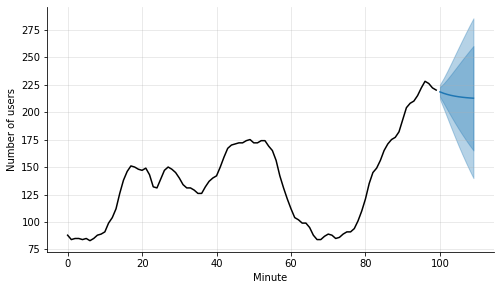

In [20]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

m = ms['DampedHolt']
fc = m.get_forecast(10)
ax.plot(fc.predicted_mean)
    
pint = fc.conf_int(alpha=.05)
ax.fill_between(pint.index, pint['lower value'], pint['upper value'], alpha=.33, color='C0')
pint = fc.conf_int(alpha=.2)
ax.fill_between(pint.index, pint['lower value'], pint['upper value'], alpha=.33, color='C0')

ax.set(xlabel='Minute', ylabel='Number of users')
ax.grid()

N.B.

* https://github.com/statsmodels/statsmodels/issues/6359
* https://github.com/statsmodels/statsmodels/pull/6882

## 8.3 Methods with seasonality

[FPP3 Section 8.3](https://otexts.com/fpp3/holt-winters.html)

### Holt-Winters’ additive method

### Holt-Winters’ multiplicative method

### Example: Domestic overnight trips in Australia

In [21]:
tourism = (
    pd.read_csv('data/tsibble/tourism.csv')
    .pipe(compute, lambda x: dict(
        date=pd.to_datetime(x.Quarter.str.replace(' ', ''))
    ))
)

In [22]:
aus_holidays = (
    tourism
    .query("Purpose == 'Holiday'")
    .groupby('date'.split())
    .Trips.sum()
    .reset_index()
    .set_index('date')
    .pipe(set_freq)
)
aus_holidays

,Trips
date,
1998-01-01,11806.037622
1998-04-01,9275.662074
1998-07-01,8642.488590
1998-10-01,9299.523781
1999-01-01,11172.027056
...,...
2016-10-01,10084.964670
2017-01-01,12406.418863
2017-04-01,10471.197262


`sm.tsa.statespace.ExponentialSmoothing` is more convenient in many ways, but `sm.tsa.ExponentialSmoothing` has built-in support for additive and multiplicative components.

In [23]:
Y = aus_holidays.Trips
m_add = sm.tsa.ExponentialSmoothing(Y, trend='add', seasonal='add').fit()
m_mul = sm.tsa.ExponentialSmoothing(Y, trend='mul', seasonal='mul').fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


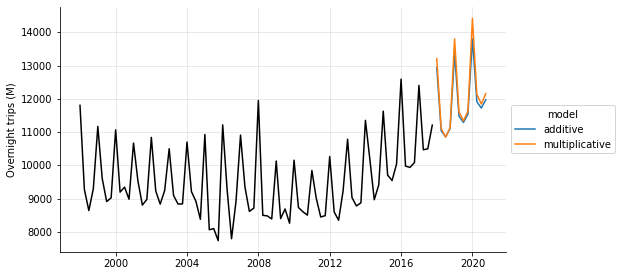

In [24]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

fc = m_add.forecast(3*4)
ax.plot(fc, label='additive')

fc = m_mul.forecast(3*4)
ax.plot(fc, label='multiplicative')

ax.set(ylabel='Overnight trips (M)')
ax.legend(title='model', **legend_right)

ax.grid()

In [25]:
m_add.params_formatted

,name,param,optimized
smoothing_level,alpha,0.157895,True
smoothing_slope,beta,0.157895,True
smoothing_seasonal,gamma,0.263158,True
initial_level,l.0,11047.638760,True
initial_slope,b.0,0.010000,True
initial_seasons.0,s.0,758.398862,True
initial_seasons.1,s.1,-1771.976686,True
initial_seasons.2,s.2,-2405.150171,True
initial_seasons.3,s.3,-1748.114980,True


In [26]:
m_mul.params_formatted

,name,param,optimized
smoothing_level,alpha,0.157895,True
smoothing_slope,beta,0.157895,True
smoothing_seasonal,gamma,0.210526,True
initial_level,l.0,11047.638761,True
initial_slope,b.0,0.998044,True
initial_seasons.0,s.0,1.033391,True
initial_seasons.1,s.1,0.862452,True
initial_seasons.2,s.2,0.822616,True
initial_seasons.3,s.3,0.840007,True


In [27]:
s_add = summarize_holt(m_add)
s_mul = summarize_holt(m_mul)

In [28]:
s_add.head()

,observation,level,slope,season,forecast
date,,,,,
1998-01-01,11806.037622,11047.647181,0.009751,758.396230,11806.047622
1998-04-01,9275.662074,11047.654063,0.009298,-1771.981468,9275.680246
1998-07-01,8642.488590,11047.659476,0.008684,-2405.156644,8642.513190
1998-10-01,9299.523781,11047.663519,0.007951,-1748.122717,9299.553181
1999-01-01,11172.027056,10947.559789,-15.799156,591.543429,11806.067700


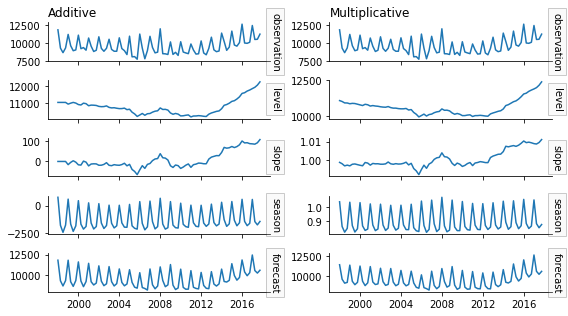

In [29]:
fig, axs = plt.subplots(5, 2, sharex=True)
for (j, s) in enumerate((s_add, s_mul)):
    for (i, field) in enumerate(s_add.columns):
        ax = axs[i,j]
        ax.plot(s[field])
        rlabel(ax, field)
axs[0,0].set_title('Additive', size='large')
axs[0,1].set_title('Multiplicative', size='large')
plt.tight_layout()

`season` is fit at a different absolute level by statsmodels compared to whatever does the work in R, but the forecast comes out comparable.

### Holt-Winters’ damped method

### Example: Holt-Winters method with daily data

In [30]:
sth_cross_ped = d = pd.read_csv('data/tsibble/pedestrian.csv')
sth_cross_ped = (
    d
    .assign(Date_Time=pd.to_datetime(d.Date_Time).dt.tz_localize(None))
    .query("Sensor == 'Southern Cross Station'")
    .query("Date_Time >= '2016-07-01'")
    .set_index('Date_Time')
    .resample('1d').sum()
    .pipe(set_freq)
)
sth_cross_ped

,Time,Count
Date_Time,,
2016-07-01,276,11712
2016-07-02,276,2361
2016-07-03,276,8203
2016-07-04,276,17352
2016-07-05,276,16265
...,...,...
2016-12-27,276,3446
2016-12-28,276,5577
2016-12-29,276,4956


In [31]:
split = '2016-08-01'
dtrain, dtest = sth_cross_ped[:split], sth_cross_ped[split:'2016-09-01']

In [32]:
m = sm.tsa.ExponentialSmoothing(dtrain.Count, trend='add', damped=True, seasonal='mul').fit()

In [33]:
RMSE(dtrain.Count, m.fittedvalues)

412.1686540935377

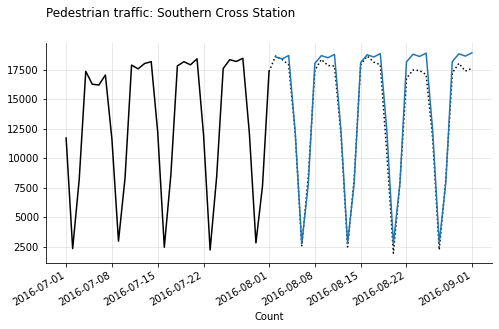

In [34]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest.Count, 'k:')

fc = m.forecast(31)
ax.plot(fc)
ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [35]:
RMSE(dtest.Count, fc)

855.7960732793663

Again, it's tricky to get statsmodels to give prediction intervals for this sort of model.  If we use the statespace model, we get prediction intervals, but then the model is strictly additive.

In [36]:
m = sm.tsa.statespace.ExponentialSmoothing(
    dtrain.Count,
    trend=True,
    seasonal=7,
    damped_trend=True
).fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:348: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[0])) * (high - low) + low)
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:356: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)
/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:371: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)


In [37]:
RMSE(dtrain.Count, m.fittedvalues)

486.6979564963113

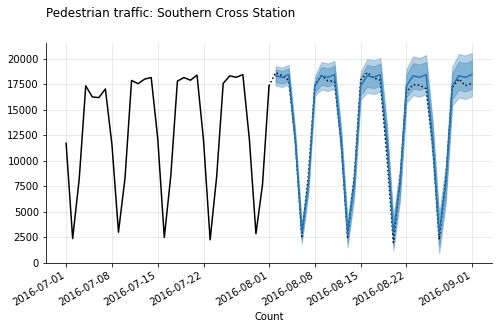

In [38]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest[:'2016-09-01'].Count, 'k:')

fc = m.get_forecast(31)
ax.plot(fc.predicted_mean)

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, color='C0', alpha=.33)

ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [39]:
RMSE(dtest.Count, fc.predicted_mean)

631.9406933188095

We can also fit in logspace to obtain an effectively multiplicative model.

In [40]:
m = sm.tsa.statespace.ExponentialSmoothing(
    np.log1p(dtrain.Count),
    trend=True,
    seasonal=7,
    damped_trend=True
).fit()

/home/mike/work/self/fpp3-python-readalong/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [41]:
e1 = np.expm1

In [42]:
RMSE(dtrain.Count, e1(m.fittedvalues))

421.7883860751796

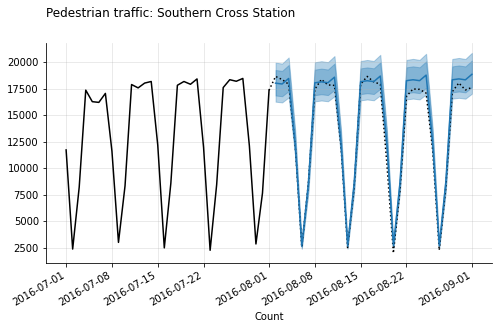

In [43]:
fig, ax = plt.subplots()
ax.plot(dtrain.Count, 'k')
ax.plot(dtest[:'2016-09-01'].Count, 'k:')

fc = m.get_forecast(31)
ax.plot(e1(fc.predicted_mean))

ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.33)

ax.set(xlabel='Count')
suptitle('Pedestrian traffic: Southern Cross Station')
fig.autofmt_xdate()
ax.grid()

In [44]:
RMSE(dtest.Count, e1(fc.predicted_mean))

779.4277387907227

This approach seems to give a somewhat worse RMSE on the test set, 780 compared with 632 for the additive statespace model.  Interestingly however, The additive statespace model appears to outperform the traditional (Ad,M) (test set RMSE=856) in this case.

## 8.4 A taxonomy of exponential smoothing methods

[FPP3 Section 8.4](https://otexts.com/fpp3/taxonomy.html)

## 8.5 Innovations state space models for exponential smoothing

[FPP3 Section 8.5](https://otexts.com/fpp3/ets.html)

Oh, here's the state space stuff!

### ETS(A,N,N): simple exponential smoothing with additive errors

### ETS(M,N,N): simple exponential smoothing with multiplicative errors

### ETS(A,A,N): Holt’s linear method with additive errors

### ETS(M,A,N): Holt’s linear method with multiplicative errors

### Other ETS models

## 8.6 Estimation and model selection

[FPP3 Section 8.6](https://otexts.com/fpp3/estimation-and-model-selection.html)

### Estimating ETS models

### Model selection

### Example: Domestic holiday tourist visitor nights in Australia

**TODO**

## 8.7 Forecasting with ETS models

[FPP3 Section 8.7](https://otexts.com/fpp3/ets-forecasting.html)

In [45]:
Y = aus_holidays.Trips
m = sm.tsa.statespace.ExponentialSmoothing(Y, trend=True, seasonal=4, damped_trend=True).fit()

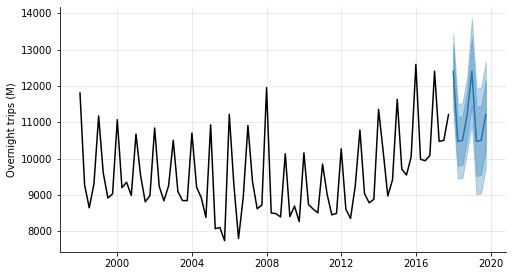

In [46]:
fig, ax = plt.subplots()
ax.plot(Y, 'k')

fc = m.get_forecast(8)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

ax.set(ylabel='Overnight trips (M)')

ax.grid()

### Prediction intervals

<hr/>

[Previous: Time series regression models](07-Time-series-regression-models.ipynb)
• [Contents](Contents.ipynb)
• [Next: ARIMA-models](09-ARIMA-models.ipynb)